In [3]:
%pylab
%matplotlib inline

from sklearn import svm
from sklearn import preprocessing
def readfile(filename, n,d):
    y = np.zeros(n) # targets
    X = np.zeros((n,d)) # input matrix each row is a sample data point
    li = 0 
    with open(filename, "rb") as f:
        for line in f:
           if li>=n : 
             break;
           parts = line.split()
           y[li] = float(parts[0])
           for i in range(len(parts)): 
                if i >0 and parts[i] != '\n': 
                    fparts = parts[i].split(":")
                    X[li,int(fparts[0])-1] = float(fparts[1])
           li = li +1
    return (y,X)
def get_data_plot(stats):
    xvals = np.array([x1 for x1, y1 in stats])
    yvals = np.array([y1 for x1, y1 in stats])
    return (xvals,yvals)


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
def w_alpha(alpha,X): # check the equation 3 of (SDCA) paper
    n, d = X.shape
    w = np.zeros(d)
    for i in range(n): 
        w = w + alpha[i]*X[i,:]
    return w
def dual_obj(w, alpha,X,C): # computes the dual function value for a given parameter alpha 
    da = 0
    n, d = X.shape
    for i in range(n): 
        if alpha[i] <= C and alpha[i] >= 0:
            da = da + alpha[i]
        else:
            da = da + float("inf")
    da = da - 0.5*np.square(np.linalg.norm(w_alpha(alpha,X)))
    return da
def primal_func(w,alpha,X,C): # computes the primal value for the given parameter w
    n, d = X.shape
    pw = 0
    for i in range(n): 
        pw = pw + max(0,1-np.dot(w,X[i,:]))
    pw = pw*C
    pw = pw + 0.5*np.square(np.linalg.norm(w))
    return pw

SyntaxError: invalid syntax (<ipython-input-4-2be4afcb6bb4>, line 21)

In [5]:
from sklearn.linear_model import Ridge

n = 32561; 
d = 123; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
clf = Ridge(alpha=1.0)
clf.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [6]:
primal clf.coef_

array([-0.10867908, -0.12945306,  0.02629357,  0.1197598 ,  0.09207876,
        0.06585366, -0.0634794 ,  0.18998216,  0.19872722, -0.00420835,
       -0.02607207, -0.27030544,  0.07529419, -0.0359315 ,  0.00759868,
        0.00376339,  0.00851887,  0.01605056, -0.15131084, -0.02367359,
        0.05180304, -0.06797777,  0.20335344, -0.00589927, -0.00590632,
       -0.06101817, -0.1238294 ,  0.09779827,  0.00349539, -0.07916451,
        0.02175246,  0.2633781 , -0.06536794, -0.0574329 , -0.21545915,
       -0.06797777, -0.02367359, -0.01180559,  0.31891609,  0.12000135,
       -0.12072957, -0.09375826, -0.08047217, -0.05331644, -0.04979319,
        0.27806828,  0.14926676, -0.02441446, -0.02804767,  0.08006896,
        0.24434508,  0.13386585, -0.09262492, -0.09057021,  0.012441  ,
       -0.1960744 , -0.07996604,  0.02266473,  0.16803914, -0.20849604,
        0.36885461, -0.10052963,  0.14010704, -0.16489979, -0.09879277,
       -0.14473946,  0.03002925,  0.03947572, -0.05131313, -0.02

In [11]:
def online_svm(A, C, num_effective_passes,init_sample_size,obj = dual_obj, verbose=False):
  #each row contains a data point with dim d
  # active_stargey: case -1 (nothing), case 1 (reset the block list in each iteration), case 2 ( holding a queue with a limited size), case 3 (online random permutation replacement) 
  inv_sq_row_norms = np.divide(1.0, np.square(np.linalg.norm(A, axis=1)))
  n, d = A.shape
  rperm = np.random.permutation(n);
  alpha = np.zeros(n)
  w = w_alpha(alpha,A)
  obj_value = obj(w,alpha,A,C) 
  sample_size = init_sample_size
  if verbose:
    print(" Initial objective value: {}".format(obj_value))
  past_ef_pass = 0
 
  stats = [(0.0, obj_value)]
  completed_effective_passes = 0.0

  while completed_effective_passes < num_effective_passes:
    coords = rperm[np.random.permutation(sample_size)] 
    for ii in coords:
        alpha_i_old = alpha[ii]
        xi = A[ii,:]
        inv_sqi = inv_sq_row_norms[ii]
       
        # coordinate update step 
        delta_alpha_i = max(0,min(C,((1-np.dot(xi,w))*inv_sqi)+alpha_i_old)) - alpha_i_old
        alpha[ii] = alpha[ii] + delta_alpha_i
        w = w + delta_alpha_i*xi
    
    past_ef_pass = completed_effective_passes
    completed_effective_passes += len(coords) / float(n)
    obj_value = obj(w,alpha,A,C)
    stats.append((completed_effective_passes, obj_value))
    if verbose:
      print("Obj[{}]= {}".format(completed_effective_passes, obj_value))
  return (alpha, stats,w)

In [26]:
def run_small_experiment(X,y,A_in,passes,plotname,primal_accuracy = False):
    num = 4
    rep = 4
    N,d = A_in.shape
   
    main_opt = 0
   
    c = 1.00
    clf = svm.LinearSVC(loss = 'hinge', C = c, tol = 0.000001, max_iter = 1000000, fit_intercept=False)
    clf.fit(X, y)
    primal_opt =  primal_func(clf.coef_,0,A_in,c)
    print("primal obj={}".format(primal_opt))

    def dist_opt(w,alpha,A,C):
      if primal_accuracy == True: 
        return primal_func(w,alpha,A,C) - primal_opt
      return primal_opt - dual_obj(w, alpha,A,C)
            #da = 0
            #for i in range(n): 
            #    if alpha[i] <= 1 and alpha[i] >= 0:
            #        da = da + alpha[i]
            #    else:
            #        da = da + float("inf")
            #da = da / n 
            #da = da - 0.5*lambd*np.square(((1.0*n)/N)*np.linalg.norm(w_alpha(alpha,A,lambd)))
            #return primal_opt - da
    (alpha_n,stats_n,w_n) = online_svm( A_in, c, passes, obj = dual_obj,init_sample_size = N, verbose=True)
    return alpha_n
#     t_randomperm, f_randomperm = get_data_plot(stats_n)  
#     converge_rate = f_randomperm
#     plabel = "subsampled"
#     plt.plot(t_randomperm,(f_randomperm),label = plabel, marker='o')
#     (alpha_f,stats_f,w_f) =online_svm( A_in, c, passes, obj = dual_obj,init_sample_size = N, verbose=True)
#     t_randomperm, f_randomperm = get_data_plot(stats_f)  
#     converge_rate = f_randomperm
#     plabel = "all"
#     plt.plot(t_randomperm,(f_randomperm),label = plabel, marker='o')
#     lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#     plt.savefig(plotname, facecolor='w', edgecolor='w', orientation='portrait',  format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [27]:
n = 6000; 
d = 5000; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/gisette_scale"
y, X = readfile(filename,n,d)
#X = preprocessing.scale(X)
A = np.zeros((n,d))
for i in range(n): 
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
    A[i,:] = y[i]*X[i,:]
passes = 100
alpha = run_small_experiment(X,y, A,passes,"plot/gisette_scale_primal.eps",primal_accuracy =False)
for i in range(10): 
    print(alpha[i])

primal obj=[ 0.66871158]
 Initial objective value: 0.0
Obj[1.0]= 0.177722746585
Obj[2.0]= 0.291194981912
Obj[3.0]= 0.357857896594
Obj[4.0]= 0.408916589404
Obj[5.0]= 0.447337763417
Obj[6.0]= 0.479741632084
Obj[7.0]= 0.506638715073
Obj[8.0]= 0.529228913117
Obj[9.0]= 0.547870168187
Obj[10.0]= 0.563514465112
Obj[11.0]= 0.576829948317
Obj[12.0]= 0.587765870569
Obj[13.0]= 0.59710896824
Obj[14.0]= 0.605819413167
Obj[15.0]= 0.613304328943
Obj[16.0]= 0.61978880076
Obj[17.0]= 0.625548922551
Obj[18.0]= 0.630154167077
Obj[19.0]= 0.634500175107
Obj[20.0]= 0.638100688609
Obj[21.0]= 0.641361427718
Obj[22.0]= 0.644119984803
Obj[23.0]= 0.646696309404
Obj[24.0]= 0.648951368568
Obj[25.0]= 0.65089038827
Obj[26.0]= 0.652689992139
Obj[27.0]= 0.654328624657
Obj[28.0]= 0.655686085612
Obj[29.0]= 0.656967829583
Obj[30.0]= 0.658103484655
Obj[31.0]= 0.659061082967
Obj[32.0]= 0.659926430167
Obj[33.0]= 0.660732222959
Obj[34.0]= 0.661423738994
Obj[35.0]= 0.662082128872
Obj[36.0]= 0.662647518478
Obj[37.0]= 0.66316401

primal obj=[ 11433.8077058]
 Initial objective value: 0.0
Obj[0.499984644206]= 580.932525068
Obj[0.999969288413]= 1109.36225934
Obj[1.49995393262]= 1628.31385485
Obj[1.99993857683]= 2149.12398033
Obj[2.49992322103]= 2628.57838193
Obj[2.99990786524]= 3096.56792444
Obj[3.49989250944]= 3532.05820985
Obj[3.99987715365]= 3920.46240756
Obj[4.49986179786]= 4258.7174582
Obj[4.99984644206]= 4534.1935542
Obj[5.49983108627]= 4764.43295429
Obj[5.99981573048]= 4944.87205045
Obj[6.49980037468]= 5088.0975754
 Initial objective value: 0.0
Obj[1.0]= 1169.63006732
Obj[2.0]= 2227.50132145
Obj[3.0]= 3258.77514592
Obj[4.0]= 4279.19038825
Obj[5.0]= 5257.66549275
Obj[6.0]= 6192.28699689


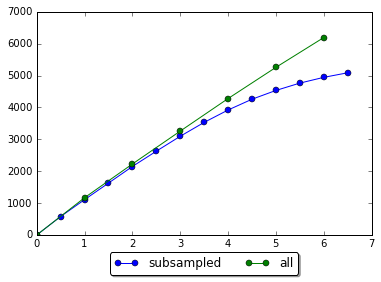

In [5]:
n = 32561; 
d = 123; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/a9a"
y, X = readfile(filename,n,d)
#X = preprocessing.scale(X)
A = np.zeros((n,d))
for i in range(n): 
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
    A[i,:] = y[i]*X[i,:]
passes = 6
run_small_experiment(X,y, A,passes,"plot/a9a_primal.eps",primal_accuracy =False)

In [16]:
def run_small_experiment2(X,y,A_in,lambd,passes,plotname,primal_opt = -1,primal_accuracy = False):
    num = 4
    rep = 4
    N,d = A_in.shape
    #if primal_opt == -1:
    #    clf = svm.LinearSVC(loss = 'hinge', C = 1.0/(N*lambd),fit_intercept=False, tol=1e-6, max_iter=N*passes*20)
    #    clf.fit(X, y)
    #    primal_opt =  primal_func(clf.coef_,A_in,lambd)
    
    
    print("primal_obj[opt]={}".format(primal_opt))
    main_opt = 0
    for i in range(num):
        n = int(1.0*N/(power(2,i)))
        print("n:{}".format(n))
        inds = np.random.randint(N, size=n);
        A = np.zeros((n,d))
        A = A_in[inds,:]
        X_sub = X[inds,:]
        y_sub = y[inds]
        lambd = 1.0/n
        
        clf = svm.LinearSVC(loss = 'hinge', C = 1.0, tol = 0.00001, max_iter = 100000, fit_intercept=False)
        clf.fit(X_sub, y_sub)
        primal_opt =  primal_func(clf.coef_,0,A,1.0)
        print('primal[{}] = {}'.format(n,primal_opt))
       # (alpha_s,stats_s,w_s) = svm_randomperm( A, lambd, passes*200, obj = dual_obj)
       # primal_opt = primal_func(w_s,A,lambd)
        print("primal obj={}".format(primal_opt))
        if i == 1: 
            main_opt = primal_opt
        def dist_opt(w,alpha,A,lambd):
          if primal_accuracy == True: 
            return primal_func(w,A,lambd) - primal_opt
          return primal_opt - dual_obj(w, alpha,A,lambd)
            #da = 0
            #for i in range(n): 
            #    if alpha[i] <= 1 and alpha[i] >= 0:
            #        da = da + alpha[i]
            #    else:
            #        da = da + float("inf")
            #da = da / n 
            #da = da - 0.5*lambd*np.square(((1.0*n)/N)*np.linalg.norm(w_alpha(alpha,A,lambd)))
            #return primal_opt - da
#         (alpha_n,stats_n,w_n) =svm_randomperm( A, 1.0/n, passes*power(2,i), obj = dist_opt)
#         t_randomperm, f_randomperm = get_data_plot(stats_n)  
#         converge_rate = f_randomperm
#         for cc in range(rep):
#           (alpha_n,stats_n,w_n) =svm_randomperm( A, lambd, passes*power(2,i), obj = dist_opt)
#           t_randomperm, f_randomperm = get_data_plot(stats_n)
#           converge_rate = np.add(converge_rate,f_randomperm)
#         converge_rate = np.divide(converge_rate,rep)
#         t_randomperm = np.multiply(t_randomperm,n)
#         plabel = "size=%i" % n
#         plt.plot(t_randomperm,np.log(f_randomperm),label = plabel, marker='o')
#     lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
#     plt.savefig(plotname, facecolor='w', edgecolor='w',
#         orientation='portrait',  format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [17]:
n = 6000; 
d = 5000; 
import readsvm 
#filename = "../datasets/rcv1_train.binary"
filename = "../datasets/gisette_scale"
y, X = readfile(filename,n,d)
#X = preprocessing.scale(X)
A = np.zeros((n,d))
for i in range(n): 
    if(y[i]==2 or y[i] == 0):
        y[i] = -1;
    A[i,:] = y[i]*X[i,:]
lambd = 0.01
passes = 6
run_small_experiment2(X,y, A,lambd,passes,"plot/gisette_scale_primal.eps",primal_accuracy = True)

primal_obj[opt]=-1
n:6000
primal[6000] = [ 0.47667857]
primal obj=[ 0.47667857]
n:3000
primal[3000] = [ 0.29890367]
primal obj=[ 0.29890367]
n:1500
primal[1500] = [ 0.17830362]
primal obj=[ 0.17830362]
n:750
primal[750] = [ 0.10398927]
primal obj=[ 0.10398927]


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  4.,  0.,  0.,  1.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

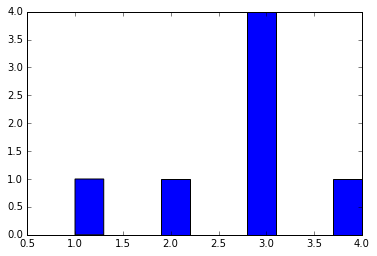

In [3]:
a = [1,2,3,4,3,3,3]
plt.hist(a)

In [36]:
sum(alpha>=0)

6000